In [ ]:
#https://github.com/raghav1810/Music-analysis-and-Year-prediction/blob/master/Evolution%20of%20Pop%20Music.ipynb

In [46]:
from pyspark.sql import SparkSession

spark_session = SparkSession\
        .builder\
        .master("spark://master:7077") \
        .appName("whatever")\
        .getOrCreate()

spark_context = spark_session.sparkContext

In [47]:
# collect all directories where all h5 files are

from hdfs import InsecureClient
client = InsecureClient("http://master:50070", user="ubuntu")

paths = set()
for path, dirs, _files in client.walk("/home/ubuntu"):
    if not dirs and not path.endswith("AdditionalFiles"):
        paths.add(path)

In [48]:
import math
import time
import h5py
import io
from statistics import mean

def get_year(h5):
    return int(h5["musicbrainz"]["songs"][0][1])

def get_danceability(h5):
    asd = float(h5["metadata"]["songs"][0][2])
    if math.isnan(asd):
        return 0.0
    else:
        return asd

def f(tup):
    _path, data = tup
    with io.BytesIO(data) as b, h5py.File(b, "r") as f:
        return get_year(f), get_danceability(f)

before = time.perf_counter()
h5s = spark_context.union([spark_context.binaryFiles("hdfs://master:9000" + p).map(f) for p in paths])

asd = h5s.filter(lambda x: x[0] != 0 and x[1] > 0)\
         .groupByKey()\
         .map(lambda x: (x[0], mean(x[1])))\
         .sortBy(lambda x: x[0])\
         .collect()

print("it took {}".format(time.perf_counter() - before))

it took 809.9659100319259


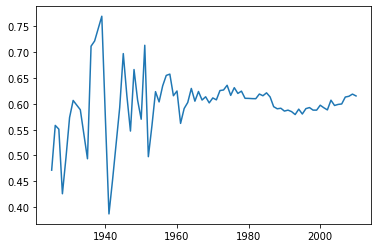

In [22]:
# graph is from 4 workers 16GB
import matplotlib.pyplot as plt
xs, ys = zip(*asd)
plt.plot(xs, ys)
plt.show()

In [ ]:
# for debugging, ignore
def f(tup):
    import h5py
    import io
    import math
    _path, data = tup
    with io.BytesIO(data) as b, h5py.File(b, "r") as f:
        asd = float(f["metadata"]["songs"][0][2])
        return asd == 0.0 or math.isnan(asd)

h5s = spark_context.union([spark_context.binaryFiles("hdfs://master:9000" + p).map(f) for p in paths])

from pprint import pprint
pprint(h5s.count())
pprint(h5s.filter(lambda x: x).count())

In [48]:
# for debugging, ignore
import h5py
from pprint import pprint
with h5py.File("/home/ubuntu/hej.h5", "r") as f:
    #pprint(str(list(f)))
    #pprint(str(list(f["analysis"]["songs"].attrs.items())))
    #pprint(str(f["analysis"]["songs"][0][23]))
    #print(str(int(f["analysis"]["songs"][0][23]) == 0))
    # 23 == loudness
    # 2 == danceability
    
    pprint(str(f["musicbrainz"]["songs"][0][1]))

'2006'


In [45]:
spark_context.stop()